In [1]:
# 2. .env 파일에서 API 키를 불러옵니다.
import os
from dotenv import load_dotenv

load_dotenv()
print(".env 파일이 로드되었습니다.")

# 3. 전체 시스템의 기억 상자(State)를 정의합니다.
from typing import TypedDict, List, Optional
from langchain_core.documents import Document

class AgentState(TypedDict):
    # --- 공통 입력 ---
    # 사용자의 초기 요청 (채팅 또는 모임 등록 정보)
    # Optional[]은 값이 있을 수도, 없을 수도 있다는 의미입니다.
    user_input: dict
    
    # --- 라우팅 결과 ---
    # 어떤 전문가에게 일을 보낼지 결정
    route: str

    # --- 전문가 에이전트들과 주고받을 데이터 ---
    # 모임 매칭 에이전트용 데이터
    title: Optional[str]
    description: Optional[str]
    
    # 취미 탐색 에이전트용 데이터
    # (설문조사 질문/답변, 최종 추천 결과 등)
    hobby_reco_session: Optional[dict]
    
    # --- 최종 결과 ---
    final_answer: str

print("마스터 에이전트의 AgentState가 정의되었습니다.")

.env 파일이 로드되었습니다.
마스터 에이전트의 AgentState가 정의되었습니다.


In [2]:
# --- 셀 2: 라우터 노드 정의 ---

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# 1. LLM 모델을 준비합니다.
llm = ChatOpenAI(model="gpt-4o-mini")
print("LLM 모델이 준비되었습니다.")

# 2. 라우팅을 위한 프롬프트 템플릿을 만듭니다.
# LLM에게 사용자의 요청을 보여주고, 두 가지 선택지 중 하나를 고르게 합니다.
routing_prompt = ChatPromptTemplate.from_template(
    """당신은 사용자의 요청을 분석하여 어떤 담당자에게 전달해야 할지 결정하는 AI 라우터입니다.
    사용자의 요청을 보고, 아래 두 가지 경로 중 가장 적절한 경로 하나만 골라 그 이름만 정확히 답변해주세요.

    [경로 설명]
    1. `meeting_matching`: 사용자가 '새로운 모임'을 만들려고 할 때, 기존에 있던 '유사한 모임'을 추천해주는 경로입니다. (입력에 title, description 등이 포함됩니다)
    2. `hobby_recommendation`: 사용자에게 '새로운 취미' 자체를 추천해주는 경로입니다. (사용자가 채팅으로 "취미 추천해줘" 와 같이 질문합니다)

    [사용자 요청]:
    {user_input}

    [판단 결과 (meeting_matching 또는 hobby_recommendation)]:
    """
)

# 3. LLM의 답변을 문자열로 받기 위한 체인을 만듭니다.
router_chain = routing_prompt | llm | StrOutputParser()

# 4. 라우터 노드 함수를 정의합니다.
def route_request(state: AgentState):
    """사용자의 입력을 보고 어떤 전문가에게 보낼지 결정합니다."""
    print("--- ROUTING ---")
    
    user_input = state['user_input']
    
    # LLM을 호출하여 라우팅 결정을 내립니다.
    route_decision = router_chain.invoke({"user_input": user_input})
    
    # 불필요한 공백이나 따옴표를 제거합니다.
    cleaned_decision = route_decision.strip().replace("'", "").replace('"', '')
    
    print(f"라우팅 결정: {cleaned_decision}")
    
    # 결정된 경로를 AgentState에 저장합니다.
    return {"route": cleaned_decision}

print("라우터 노드가 정의되었습니다.")

LLM 모델이 준비되었습니다.
라우터 노드가 정의되었습니다.


In [3]:
# --- 셀 3: 전문가 호출 노드 정의 ---

import requests # API 요청을 보내기 위한 라이브러리
import json
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_pinecone import PineconeVectorStore
from langgraph.graph import StateGraph, END
from langchain_core.documents import Document
from typing import List, TypedDict

# --- 전문가 1: 모임 매칭 에이전트 호출 노드 ---
def call_meeting_matching_agent(state: AgentState):
    """'모임 매칭 에이전트'를 실행하고 결과를 받아옵니다."""
    print("--- CALLING: Meeting Matching Agent ---")

    # ▼▼▼▼▼▼ 이전 '모임 매칭 에이전트' 노트북의 모든 코드가 여기에 포함됩니다 ▼▼▼▼▼▼

    # 1. 모임 매칭 에이전트의 State 정의
    class MeetingAgentState(TypedDict):
        title: str
        description: str
        time: str       # 추가
        location: str   # 추가
        query: str
        context: List[Document]
        answer: str
        rewrite_count: int
        decision: str

    # 2. 모임 매칭 에이전트용 LLM 및 DB 준비
    meeting_llm = ChatOpenAI(model="gpt-4o-mini")
    
    # 중요: .env 파일에 '모임 매칭 에이전트'가 사용할 인덱스 이름을 따로 지정해주세요.
    # 예: PINECONE_INDEX_NAME_MEETING="moit-agent-index"
    meeting_index_name = os.getenv("PINECONE_INDEX_NAME_MEETING")
    if not meeting_index_name:
        raise ValueError("'.env' 파일에 PINECONE_INDEX_NAME_MEETING 변수를 설정해야 합니다.")
        
    embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')
    vector_store = PineconeVectorStore.from_existing_index(
        index_name=meeting_index_name,
        embedding=embedding_function
    )
    retriever = vector_store.as_retriever(search_kwargs={'k': 2})

    # 3. 모임 매칭 에이전트의 모든 노드 함수 정의
    # Node 3-1: prepare_query
    prepare_query_prompt = ChatPromptTemplate.from_template(
        """당신은 사용자가 입력한 정보를 바탕으로 유사한 다른 정보를 검색하기 위한 최적의 검색어를 만드는 전문가입니다.
        아래 [모임 정보]를 종합하여, 벡터 데이터베이스에서 유사한 모임을 찾기 위한 가장 핵심적인 검색 질문을 한 문장으로 만들어주세요.

        [모임 정보]:
        - 제목: {title}
        - 설명: {description}
        - 시간: {time}
        - 장소: {location}
        """
    )
    prepare_query_chain = prepare_query_prompt | meeting_llm | StrOutputParser()
    def prepare_query(m_state: MeetingAgentState):
        print("--- (Sub) 0. PREPARE QUERY ---")
        query = prepare_query_chain.invoke({
            "title": m_state['title'], 
            "description": m_state['description'],
            "time": m_state.get('time', ''),      # time 정보 추가
            "location": m_state.get('location', '') # location 정보 추가
        })
        print("생성된 검색 쿼리:", query)
        return {"query": query}

    # Node 3-2: retrieve
    def retrieve(m_state: MeetingAgentState):
        print("--- (Sub) 1. RETRIEVE ---")
        context = retriever.invoke(m_state['query'])
        return {"context": context}

    # Node 3-3: generate
    generate_prompt = ChatPromptTemplate.from_template(
        """당신은 MOIT 플랫폼의 친절한 모임 추천 AI입니다.
        사용자에게 "혹시 이런 모임은 어떠세요?" 라고 제안하는 말투로, 반드시 아래 [검색된 정보]를 기반으로 유사한 모임이 있다는 것을 명확하게 설명해주세요.

        [검색된 정보]:
        {context}

        [사용자 질문]:
        {query}
        """
    )
    generate_chain = generate_prompt | meeting_llm | StrOutputParser()
    def generate(m_state: MeetingAgentState):
        print("--- (Sub) 2. GENERATE ---")
        context = "\n\n".join(doc.page_content for doc in m_state['context'])
        answer = generate_chain.invoke({"context": context, "query": m_state['query']})
        return {"answer": answer}

    # Node 3-4: check_helpfulness
    check_helpfulness_prompt = ChatPromptTemplate.from_template(
        """당신은 AI 답변을 평가하는 엄격한 평가관입니다.
        주어진 [AI 답변]이 사용자의 [원본 질문] 의도에 대해 유용한 제안을 하는지 평가해주세요.
        'helpful' 또는 'unhelpful' 둘 중 하나로만 답변해야 합니다.

        [원본 질문]: {query}
        [AI 답변]: {answer}
        """
    )
    check_helpfulness_chain = check_helpfulness_prompt | meeting_llm | StrOutputParser()
    def check_helpfulness(m_state: MeetingAgentState):
        print("--- (Sub) 3. CHECK HELPFULNESS ---")
        result = check_helpfulness_chain.invoke({"query": m_state['query'], "answer": m_state['answer']})
        decision = "helpful" if 'helpful' in result.lower() else "unhelpful"
        return {"decision": decision}

    # Node 3-5: rewrite_query
    rewrite_query_prompt = ChatPromptTemplate.from_template(
        """당신은 사용자의 질문을 더 좋은 검색 결과가 나올 수 있도록 명확하게 다듬는 프롬프트 엔지니어입니다.
        주어진 [원본 질문]을 바탕으로, 벡터 데이터베이스에서 더 관련성 높은 모임 정보를 찾을 수 있는 새로운 검색 질문을 하나만 만들어주세요.
        결과는 오직 새로운 검색 질문 텍스트만 포함해야 합니다.

        [원본 질문]: {query}
        """
    )
    rewrite_query_chain = rewrite_query_prompt | meeting_llm | StrOutputParser()
    def rewrite_query(m_state: MeetingAgentState):
        print("--- (Sub) 4. REWRITE QUERY ---")
        new_query = rewrite_query_chain.invoke({"query": m_state['query']})
        count = m_state.get('rewrite_count', 0) + 1
        return {"query": new_query, "rewrite_count": count}

    # 4. 모임 매칭 에이전트 그래프 조립 및 컴파일
    graph_builder = StateGraph(MeetingAgentState)
    graph_builder.add_node("prepare_query", prepare_query)
    graph_builder.add_node("retrieve", retrieve)
    graph_builder.add_node("generate", generate)
    graph_builder.add_node("check_helpfulness", check_helpfulness)
    graph_builder.add_node("rewrite_query", rewrite_query)
    
    graph_builder.set_entry_point("prepare_query")
    graph_builder.add_edge("prepare_query", "retrieve")
    graph_builder.add_edge("retrieve", "generate")
    graph_builder.add_edge("generate", "check_helpfulness")
    graph_builder.add_conditional_edges(
        "check_helpfulness",
        lambda state: state['decision'],
        {"helpful": END, "unhelpful": "rewrite_query"}
    )
    graph_builder.add_edge("rewrite_query", "retrieve")
    
    meeting_agent = graph_builder.compile()
    
    # ▲▲▲▲▲▲ 여기까지가 이전 '모임 매칭 에이전트' 노트북의 코드입니다 ▲▲▲▲▲▲


    # 5. 마스터 AgentState에서 정보를 꺼내 meeting_agent를 실행합니다.
    user_input = state['user_input']
    initial_state = {
        "title": user_input.get("title", ""),
        "description": user_input.get("description", ""),
        "time": user_input.get("time", ""),          # 추가
        "location": user_input.get("location", ""),    # 추가
        "rewrite_count": 0
    }
    
    # meeting_agent를 실행하고 최종 결과만 받아옵니다.
    final_result_state = meeting_agent.invoke(initial_state)
    final_answer = final_result_state.get("answer", "유사한 모임을 찾지 못했습니다.")
    
    print("모임 매칭 에이전트 결과:", final_answer)
    # 최종 결과를 마스터 AgentState에 저장하여 반환합니다.
    return {"final_answer": final_answer}



# --- 전문가 2: 취미 추천 에이전트 호출 노드 ---
def call_hobby_recommendation_agent(state: AgentState):
    """'취미 추천 에이전트(API)'를 호출하고 결과를 받아옵니다."""
    print("--- CALLING: Hobby Recommendation Agent ---")
    
    # 1. 친구가 만든 app.py 서버의 주소
    #    (API 서버를 실행해야 이 코드가 작동합니다)
    url = "http://127.0.0.1:5000/recommend"
    
    # 2. API로 보낼 데이터 (사용자의 설문조사 답변)
    #    (실제 서비스에서는 이 부분을 사용자와의 대화를 통해 채워야 합니다)
    user_input = state['user_input']
    
    try:
        # 3. API에 POST 요청을 보내고 응답을 받습니다.
        response = requests.post(url, json=user_input)
        response.raise_for_status() # 오류가 있으면 예외 발생
        
        # 4. 받은 JSON 결과를 사람이 읽기 좋은 문장으로 변환합니다.
        recommendations = response.json()
        if not recommendations:
            final_answer = "아쉽지만 현재 조건에 맞는 취미를 찾지 못했어요. 조건을 조금 바꿔서 다시 시도해볼까요?"
        else:
            # 상위 3개만 추천
            top3 = recommendations[:3]
            answer_parts = ["회원님께는 이런 취미들을 추천해 드려요!\n"]
            for reco in top3:
                answer_parts.append(f"\n- **{reco['name_ko']}**: {reco['short_desc']} (추천 이유: {reco['reason']})")
            final_answer = "".join(answer_parts)

    except requests.exceptions.RequestException as e:
        print(f"API 호출 오류: {e}")
        final_answer = "취미 추천 서버에 문제가 발생하여 연결할 수 없습니다. 잠시 후 다시 시도해주세요."
        
    print("취미 추천 에이전트 결과:", final_answer)
    return {"final_answer": final_answer}

print("전문가 호출 노드가 정의되었습니다.")

c:\Users\user\anaconda3\envs\moit_agent_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\user\anaconda3\envs\moit_agent_env\Lib\site-packages\langchain_pinecone\__init__.py:3: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langchain_pinecone.vectorstores import Pinecone, PineconeVectorStore


전문가 호출 노드가 정의되었습니다.


In [4]:
# --- [수정] 셀 4: 최종 그래프 조립 (오타 수정 버전) ---

from langgraph.graph import StateGraph, END

# 1. 마스터 에이전트의 그래프 빌더를 생성합니다.
master_graph_builder = StateGraph(AgentState)

# 2. 지금까지 만든 모든 노드들을 그래프에 등록합니다.
master_graph_builder.add_node("router", route_request)
master_graph_builder.add_node("meeting_matcher", call_meeting_matching_agent)
master_graph_builder.add_node("hobby_recommender", call_hobby_recommendation_agent)

# 3. 작업 흐름(엣지)을 연결합니다.
master_graph_builder.set_entry_point("router")

# 'router'의 결정에 따라 다음 목적지를 정합니다.
master_graph_builder.add_conditional_edges(
    "router",
    lambda state: state['route'],
    {
        "meeting_matching": "meeting_matcher",
        
        # 이 부분의 키(key)를 router의 출력과 똑같이 수정했습니다!
        "hobby_recommendation": "hobby_recommender"
    }
)

# 각 전문가의 작업이 끝나면, 전체 흐름을 종료합니다.
master_graph_builder.add_edge("meeting_matcher", END)
master_graph_builder.add_edge("hobby_recommender", END)

# 4. 최종 마스터 에이전트를 완성(컴파일)합니다.
master_agent = master_graph_builder.compile()

print("MOIT 멀티 에이전트 시스템이 성공적으로 완성되었습니다!")

MOIT 멀티 에이전트 시스템이 성공적으로 완성되었습니다!


In [5]:
# --- 셀 5: 최종 마스터 에이전트 실행 ---

# --- 시나리오 1: '모임 매칭' 테스트 ---
print("===== 시나리오 1: 모임 매칭 테스트 시작 =====")
meeting_input = {
    "user_input": {
        "title": "주말에 같이 그림 그릴 분 찾아요",
        "description": "홍대 근처에서 어반 스케치 하실 분? 초보자도 환영합니다!"
    }
}

for event in master_agent.stream(meeting_input):
    node_name = list(event.keys())[0]
    node_output = event[node_name]
    print(f"--- Event: '{node_name}' 노드 실행 ---")
    print(node_output)
    print("\n" + "="*30 + "\n")


# --- 시나리오 2: '취미 추천' 테스트 ---
print("\n\n===== 시나리오 2: 취미 추천 테스트 시작 =====")
# [⚠️ 중요!] 이 테스트를 실행하기 전에, 터미널에서 친구분의 app.py 서버를 켜두어야 합니다!
# (cd hobby_recommendation_api -> python app.py)

hobby_input = {
    "user_input": {
        "survey": {"Q6":4,"Q7":5,"Q8":4,"Q9":4,"Q10":5,"Q11":3,"Q12":2,"Q13":4,"Q14":3,"Q15":3},
        "user_context": {
            "monthly_budget": 100000,
            "session_time_limit_hours": 3.0,
            "offline_ok": True
        }
    }
}

for event in master_agent.stream(hobby_input):
    node_name = list(event.keys())[0]
    node_output = event[node_name]
    print(f"--- Event: '{node_name}' 노드 실행 ---")
    print(node_output)
    print("\n" + "="*30 + "\n")

===== 시나리오 1: 모임 매칭 테스트 시작 =====
--- ROUTING ---
라우팅 결정: meeting_matching
--- Event: 'router' 노드 실행 ---
{'route': 'meeting_matching'}


--- CALLING: Meeting Matching Agent ---
--- (Sub) 0. PREPARE QUERY ---
생성된 검색 쿼리: "홍대 근처에서 어반 스케치를 함께할 초보자 환영의 주말 모임을 찾습니다."
--- (Sub) 1. RETRIEVE ---
--- (Sub) 2. GENERATE ---
--- (Sub) 3. CHECK HELPFULNESS ---
모임 매칭 에이전트 결과: 혹시 이런 모임은 어떠세요? 홍대 근처에서 주말 오후 2시에 다 함께 보드게임을 즐기는 모임이 있어요. 초심자도 대환영이라서 누구든지 편하게 참여할 수 있는 분위기예요. 어반 스케치와는 다르지만, 함께하는 즐거움은 같은 취지니까 좋은 경험이 될 수 있을 거예요!
--- Event: 'meeting_matcher' 노드 실행 ---
{'final_answer': '혹시 이런 모임은 어떠세요? 홍대 근처에서 주말 오후 2시에 다 함께 보드게임을 즐기는 모임이 있어요. 초심자도 대환영이라서 누구든지 편하게 참여할 수 있는 분위기예요. 어반 스케치와는 다르지만, 함께하는 즐거움은 같은 취지니까 좋은 경험이 될 수 있을 거예요!'}




===== 시나리오 2: 취미 추천 테스트 시작 =====
--- ROUTING ---
라우팅 결정: hobby_recommendation
--- Event: 'router' 노드 실행 ---
{'route': 'hobby_recommendation'}


--- CALLING: Hobby Recommendation Agent ---
취미 추천 에이전트 결과: 회원님께는 이런 취미들을 추천해 드려요!

- **VR 게임**: 가상현실 장비 기반 게임 (추천 이유: 성장/숙련(유능성) · 새로운 경

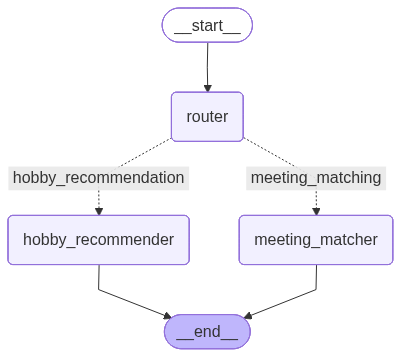

In [6]:
# --- [추가] 마스터 에이전트 전체 그래프 시각화 ---

from IPython.display import Image, display

try:
    # master_agent의 구조를 이미지로 생성합니다.
    img_data = master_agent.get_graph().draw_mermaid_png()
    
    # 노트북에 이미지를 바로 표시합니다.
    display(Image(img_data))

except Exception as e:
    print(f"그래프 시각화 중 오류가 발생했습니다: {e}")